# Import packages and figure settings

In [24]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage.measure import marching_cubes
import datetime
from pyproj import Transformer, Geod
import pandas as pd
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from windrose import WindroseAxes
from scipy.integrate import cumulative_trapezoid
from skimage import measure
from scipy.interpolate import RegularGridInterpolator
from scipy import ndimage,interpolate
from scipy.signal import find_peaks
from matplotlib.ticker import FormatStrFormatter
from shapely import Point, unary_union
import matplotlib.gridspec as gridspec
import rasterio.features
from scipy.optimize import minimize
from scipy.signal import correlate
from scipy.interpolate import CubicSpline
from scipy.optimize import  NonlinearConstraint

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.sans-serif'] = 'Arial' # Choose a nice font here
plt.rcParams['font.size'] = 12 # standard font size
plt.rcParams['mathtext.fontset'] ='dejavusans'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial'

# Parameters

In [25]:
kap  = 0.41 # von karman constant
rhos = 2380 # density gypsum
rhof = 1.225 # density air
grav = 9.81 # gravity
z00  = 1e-3 # roughness length from Gadal et al. 2020 (White Sands) and Ren et al. 2024 (Taklamakan)
d = 1e-4 # particle diameter - representive
nu = 1e-5 # viscocity - representive
phi = 0.62 # Pye and Tsoar 2009, the porosity of quartz dune sands is approximately 38%.

# Functions

In [26]:
# all functions in this block used to calculate wind velocity over terrain based on the stress perturbation theory
def get_ab(Rei,Re_di):
 
    ReiF   = True
    if not isinstance(Rei, np.ndarray):
        if type(Rei)==list:
            Rei    = np.array(Rei)
        else:
            Rei    = np.array([Rei])
            ReiF   = False            
    Re_diF = True
    if not isinstance(Re_di, np.ndarray):
        if type(Re_di)==list:
            Re_di  = np.array(Re_di)
        else:
            Re_di  = np.array([Re_di])
            Re_diF = False

    Re_d = np.logspace(-2,4, 60+1) # Re for saved solutions
    Re   = np.logspace(-2,8,100+1) # Re_d for saved solutions
    ab   = np.loadtxt('abcd.txt').reshape((4,len(Re),len(Re_d)))[:2] # saved solutions for A+iB

    # cubic interpolations for A and B based on saved solutions
    a_log10Re_log10Red = RegularGridInterpolator((np.log10(Re),np.log10(Re_d)),ab[0],method='cubic',bounds_error=False,fill_value=np.nan)
    b_log10Re_log10Red = RegularGridInterpolator((np.log10(Re),np.log10(Re_d)),ab[1],method='cubic',bounds_error=False,fill_value=np.nan)

    # grid of Re and Re_d to compute A and B on
    # A and B for Re when Re_d>1e+4 is equivalent to when Re_d=1e+4 but shifted 4 decades
    Reig   = np.where(Re_di[None,:]>Re_d[-1],10**(np.log10(Rei[:,None])+np.log10(Re_d[-1])-np.log10(Re_di[None,:])),Rei[:,None])
    # A and B for Re_d<1e-2 is equivalent to Re_d=1e-2
    Re_dig = np.clip(Re_di,Re_d[0],Re_d[-1])[None,:]

    abi   = np.stack((a_log10Re_log10Red((np.log10(Reig),np.log10(Re_dig))),
                      b_log10Re_log10Red((np.log10(Reig),np.log10(Re_dig)))))

    # for Re outside solved range, A and B are well approximated with extrapolation on powerlaw fit to edges of solved range
    if np.any(Reig<Re[0]):
        abiL = np.where(Reig<Re[0],10**np.stack((np.polyval(np.polyfit(np.log10(Re[:2]),
                   np.log10(a_log10Re_log10Red((np.log10(Re[:2])[:,None],np.log10(Re_dig)))),deg=1),
                   np.log10(Reig)),
                         np.polyval(np.polyfit(np.log10(Re[:2]),
                   np.log10(b_log10Re_log10Red((np.log10(Re[:2])[:,None],np.log10(Re_dig)))),deg=1),
                   np.log10(Reig)))),np.nan)
    else:
        abiL = abi*np.nan
    if np.any(Reig>Re[-1]):
        abiR = np.where(Reig>Re[-1],10**np.stack((np.polyval(np.polyfit(np.log10(Re[-2:]),
                   np.log10(a_log10Re_log10Red((np.log10(Re[-2:])[:,None],np.log10(Re_dig)))),deg=1),
                   np.log10(Reig)),
                         np.polyval(np.polyfit(np.log10(Re[-2:]),
                   np.log10(b_log10Re_log10Red((np.log10(Re[-2:])[:,None],np.log10(Re_dig)))),deg=1),
                   np.log10(Reig)))),np.nan)
    else:
        abiR = abi*np.nan
    
    abi = np.nansum(np.stack((abiL,abi,abiR)),0)
    
    if ReiF:
        if Re_diF:
            return abi
        else:
            return abi[:,:,0]
    else:
        if Re_diF:
            return abi[:,0,:]
        else:
            return abi[:,0,0]

def get_taupx_x(x,z,d,us,nu):
    
    import numpy as np
    from scipy.fft import ifft,fft,fftfreq
    
    # calculate terrain height FFT
    kz = fft(z-np.mean(z))

    # modify kx calculation
    kx = 2*np.pi*fftfreq(len(x),d=x[1]-x[0])
    kx[kx==0] = 1e-10 
    
    A,B = get_ab(us/nu/np.abs(kx),d*us/nu)

    taupx = ifft((A*np.abs(kx)+1j*B*kx)*kz).real
    
    return taupx

def get_taupx_xy(x,y,z,d,us,nu):
    
    import numpy as np
    from scipy.fft import ifft2,fft2,fftfreq
    
    # calculate terrain height FFT
    kz = fft2(z-np.mean(z))

    # modify kx calculation
    kx = 2*np.pi*fftfreq(len(x),d=x[1]-x[0])[:,None]
    ky = 2*np.pi*fftfreq(len(y),d=y[1]-y[0])[None,:]
    kx[kx==0] = 1e-10 
    ky[ky==0] = 1e-10 
    k = (kx**2+ky**2)**0.5
    
    A,B = get_ab(us/nu/np.abs(kx),d*us/nu)

    taupx = ifft2(kx/k*(A*kx+1j*B*np.abs(kx))*kz).real
    
    return taupx

def get_taupxy_xy(x,y,z,d,us,nu):
    
    import numpy as np
    from scipy.fft import ifft2,fft2,fftfreq
    
    # calculate terrain height FFT
    kz = fft2(z-np.mean(z))

    # modify kx calculation
    kx = 2*np.pi*fftfreq(len(x),d=x[1]-x[0])[:,None]
    ky = 2*np.pi*fftfreq(len(y),d=y[1]-y[0])[None,:]
    kx[kx==0] = 1e-10 
    ky[ky==0] = 1e-10 
    k = (kx**2+ky**2)**0.5
    
    Ax,Bx = get_ab(us/nu/np.abs(kx),d*us/nu)
    Ay,By = get_ab(us/nu/np.abs(ky),d*us/nu)/2
    
    taupx = ifft2(kx/k*(Ax*kx+1j*Bx*np.abs(kx))*kz).real
    taupy = ifft2(kx/k*(Ay*ky+1j*By*np.abs(ky))*kz).real

    return taupx+1j*taupy

def get_usxy_xy(taupxy,us):
    
    tauxy = taupxy+1
    return us*np.abs(tauxy)**0.5*np.exp(1j*np.angle(tauxy))

In [ ]:
# function used to make recirculation bubbles in the dune leeside
def make_bubble(dt,varin,varout,recth,recsl,nroll=2,rbfmode='multiquadric',bzepsilon=1e-8,iterate=True):
    dx = np.diff(dt.x.data).mean()
    dy = np.diff(dt.y.data).mean()
    if (dt[varin].differentiate('x')<recth).any():
        temp0 = dt[varin].stack(p=('x','y'))
        temp1 = dt[varin].where(~((dt[varin]-dt.x*recsl)<(dt[varin].where(dt[varin].differentiate('x')<recth)-dt.x*recsl).cumulative('x').max())).to_dataset(name=varin)
        temp2 = ndimage.label(temp1[varin].isnull())
        temp5 = []
        for j in np.arange(temp2[1])+1:
            temp3 = temp2[0]==j
            temp4 = (~temp3)&ndimage.binary_dilation(temp3,iterations=nroll)
            temp3,temp4 = temp0.isel(p=np.where(temp3.flatten())[0]).to_dataset(),temp0.isel(p=np.where(temp4.flatten())[0]).to_dataset()
            rbffull = interpolate.RBFInterpolator(np.stack((temp4.x.data,temp4.y.data)).T,temp4[varin].data,kernel=rbfmode,epsilon=np.min([dx,dy]))
            temp3[varout] = (('p'),rbffull(np.stack((temp3.x.data,temp3.y.data)).T))
            if iterate:
                while (temp3[varout]<temp3[varin]).any():
                    temp4 = xr.concat((temp4,(temp3[varin].where(temp3[varout]<temp3[varin],drop=True)+bzepsilon).to_dataset()),'p')
                    rbffull = interpolate.RBFInterpolator(np.stack((temp4.x.data,temp4.y.data)).T,temp4[varin].data,kernel=rbfmode,epsilon=np.min([dx,dy]))
                    temp3[varout] = (('p'),rbffull(np.stack((temp3.x.data,temp3.y.data)).T))
            temp5.append(temp3[varout])
        return xr.merge((dt,xr.concat(temp5,'p').unstack()))
    else:
        dt[varout] = (('x','y'),np.zeros(dt[varin].shape)*np.nan)
        return dt

# extending domain to make the boundaries periodic
def make_pad(dt,varin,varout,padsl,nroll=2,rbfmode='multiquadric',bzepsilon=1e-8,iterate=True):
    z0 = dt[varin].min().data
    dx = dt.x.isel(x=slice(None,2)).diff('x').data[0]
    dy = dt.y.isel(y=slice(None,2)).diff('y').data[0]
    tempxyz = np.hstack((np.stack((dt.isel(x=0).x.data*np.ones(len(dt.isel(x=0).y)),dt.isel(x=0).y.data,dt.isel(x=0)[varin].data)),
                         np.stack((dt.isel(x=-1).x.data*np.ones(len(dt.isel(x=-1).y)),dt.isel(x=-1).y.data,dt.isel(x=-1)[varin].data)),
                         np.stack((dt.isel(y=0).x.data,dt.isel(y=0).y.data*np.ones(len(dt.isel(y=0).x)),dt.isel(y=0)[varin].data)),
                         np.stack((dt.isel(y=-1).x.data,dt.isel(y=-1).y.data*np.ones(len(dt.isel(y=-1).x)),dt.isel(y=-1)[varin].data)))).T
    padxy = -np.max(tempxyz[:,2])/padsl
    if ~((padxy<dx)&(padxy<dy)):
        padxy = np.ceil(padxy)
        temp = unary_union([Point(val[0],val[1]).buffer(-(val[2]-z0)/padsl) for val in tempxyz])
        dp = xr.Dataset(coords=dict(x=(['x'],np.arange(dt.x.min()-padxy-nroll*dx,dt.x.max()+padxy+nroll*dx+dx,dx)),
                                    y=(['y'],np.arange(dt.y.min()-padxy-nroll*dy,dt.y.max()+padxy+nroll*dy+dy,dy))))
        dp['bm'] = (('x','y'),rasterio.features.rasterize([temp],out_shape=[len(dp.y),len(dp.x)],
                                               transform=(dx,0,dp.x.isel(x=0).data,0,dy,dp.y.isel(y=0).data,0,0,1),
                                               all_touched=False).T)
        dp[varin] = dt[varin]
        dp['bm'] = (dp[varin].isnull()&(dp.bm==1))
        temp0 = dp[varin].fillna(z0).stack(p=('x','y'))
        temp2 = ndimage.label(dp.bm)
        temp5 = []
        for j in np.arange(temp2[1])+1:
            temp3 = temp2[0]==j
            temp4 = (~temp3)&ndimage.binary_dilation(temp3,iterations=nroll)
            temp3,temp4 = temp0.isel(p=np.where(temp3.flatten())[0]).to_dataset(),temp0.isel(p=np.where(temp4.flatten())[0]).to_dataset()
            rbffull = interpolate.RBFInterpolator(np.stack((temp4.x.data,temp4.y.data)).T,temp4[varin].data,kernel=rbfmode,epsilon=np.min([dx,dy]))
            temp3[varout] = (('p'),rbffull(np.stack((temp3.x.data,temp3.y.data)).T))
            if iterate:
                while (temp3[varout]<temp3[varin]).any():
                    temp4 = xr.concat((temp4,(temp3.z.where(temp3[varout]<temp3[varin],drop=True)+bzepsilon).to_dataset()),'p')
                    rbffull = interpolate.RBFInterpolator(np.stack((temp4.x.data,temp4.y.data)).T,temp4[varin].data,kernel=rbfmode,epsilon=np.min([dx,dy]))
                    temp3[varout] = (('p'),rbffull(np.stack((temp3.x.data,temp3.y.data)).T))
            temp5.append(temp3[varout])
        dp = xr.merge((dp,xr.concat(temp5,'p').unstack()))
        dp[varout] = xr.where(dp.z.isnull(),xr.where((~dp.bm)&(dp[varin].isnull()),z0,dp[varout]),dp.z)
        return dp
    else:
        dt[varout] = (('x','y'),dt[varin].data)
        dt['bm'] = (('x','y'),np.full(dt[varin].shape,False))
        return dt

In [28]:
# this function returns sand flux from the wind speed U at zU
def flux(U,zU,z0,constant=6.1,uscr=0.3):
    usabs = U*kap/np.log(zU/z0) # neutral law of the wall
    usabs[usabs<uscr] = uscr # get rid of negative unreal data
    return constant*rhof/rhos/grav*uscr*usabs**2*(1-(uscr/usabs)**2) 

# this function returns directions of wind vectors af, as +-180 from af0
def bearing_2_pm180_af0(ai,af0):
    # ai is the bearing of the wind
    # af0 is the direction of the wind vector you wish to set as the origin
    af = np.copy(ai)
    af = -af - af0 - 90
    af[af<-180] = af[af<-180] + 360
    return af

# Figure 1

http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=-106.35,32.77,-106.2,32.87&bboxSR=4326&imageSR=4326&size=1000,666&dpi=96&format=png32&transparent=true&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=-130.0,20.0,-70.0,59.99999999999999&bboxSR=4326&imageSR=4326&size=1000,666&dpi=96&format=png32&transparent=true&f=image


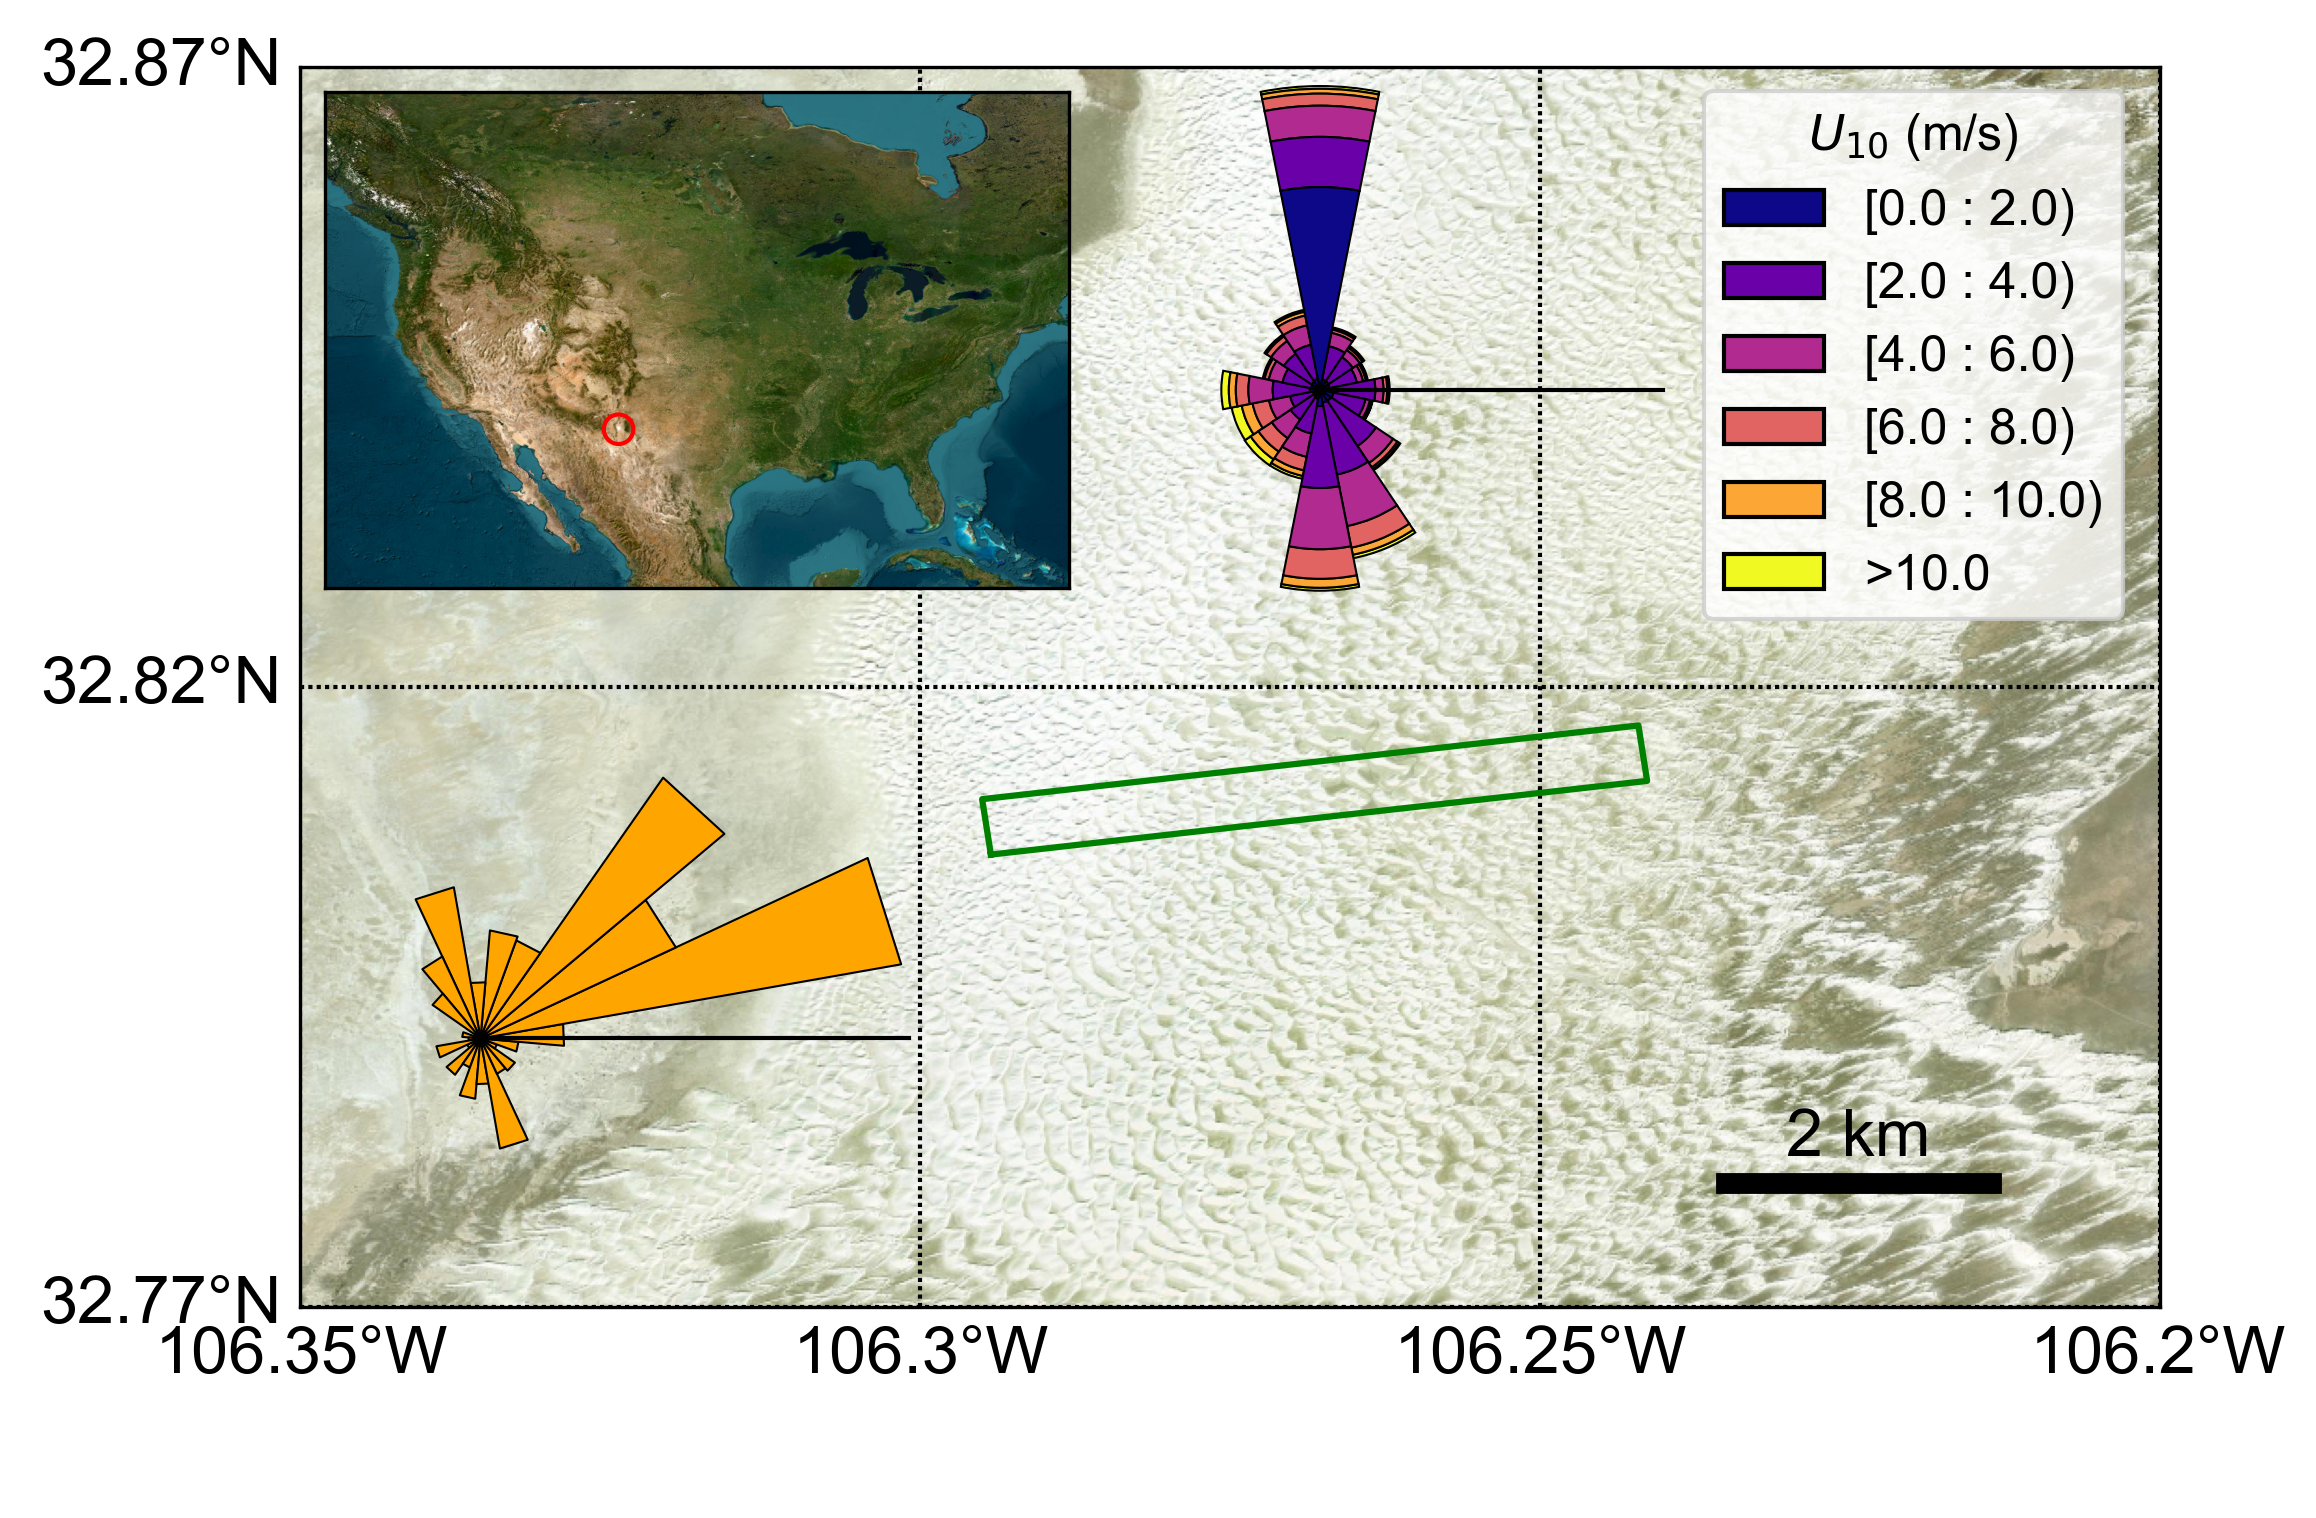

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
lw=1
fs=8
transformer = Transformer.from_crs("EPSG:26913", "EPSG:4326", always_xy=True)
lon, lat = transformer.transform(375954, 3630182)

xmin1,xmax1 = -106.35,-106.2
ymin1,ymax1 = 32.77,32.87
bmap = Basemap(epsg=4326,
               llcrnrlon=xmin1, llcrnrlat=ymin1,
               urcrnrlon=xmax1, urcrnrlat=ymax1)
bmap.arcgisimage(xpixels=1000,verbose=True)
bmap.drawmeridians(np.arange(xmin1,xmax1+0.05,0.05),linewidth=lw,color='k',labels=[True,False,False,True],fontsize=2*fs)
bmap.drawparallels(np.arange(ymin1,ymax1+0.05,0.05),linewidth=lw,color='k',labels=[True,False,False,True],fontsize=2*fs)

geod = Geod(ellps="WGS84")

# rotate
rect = np.array([[3000, 0], [8000, 0], [8000, 500], [3000, 500], [3000, 0]])
theta=-25
R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
rect_rot = rect @ R.T + [lon, lat]

# transform offsets to lon lat
lons, lats = [], []
for dx, dy in rect_rot:
    dist = np.hypot(dx, dy)                      # distance (m)
    azimuth = np.degrees(np.arctan2(dx, dy))     # orientation (deg, N=0, E=90)
    lon_pt, lat_pt, _ = geod.fwd(lon, lat, azimuth, dist)
    lons.append(lon_pt)
    lats.append(lat_pt)


ax.plot(lons, lats, 'g-')

scalebar_len_m = 2000  # 2 km
lon0, lat0 = -106.235, 32.78 
lon1, lat1, _ = geod.fwd(lon0, lat0, 90, scalebar_len_m)  # E=90
ax.plot([lon0, lon1], [lat0, lat0], 'k-', lw=5)
ax.text((lon0+lon1)/2, lat0+0.006, "2 km", ha='center', va='top',color='k',fontsize=fs*2)


axins1 = inset_axes(ax, width="40%", height="40%", loc='upper left')
xmin0,xmax0 = -130,-70
ymin0,ymax0 = 20,60
bmap2 = Basemap(epsg=4326,
               llcrnrlon=xmin0, llcrnrlat=ymin0,
               urcrnrlon=xmax0, urcrnrlat=ymax0)
bmap2.arcgisimage(xpixels=1000,verbose=True)
axins1.scatter(lon, lat, s=50, marker='o', facecolor='none', edgecolors='r')


axins2 = ax.figure.add_axes([-0.05,0.05,0.5,0.5], projection='polar')
af0 = 25 # for white sands from Gunn et al. 2020
z01 = 10 # wind speed is measured at 10 m from KHMN station in the mestwest dataset
dw = pd.read_csv('/Users/ylin0188/Desktop/code box/dfsframework code/White Sands/Wind_White_Sands_KHMN.csv')
da = 15

mAf = np.arange(-180,180+da,da)
mAmidf = mAf[1:]-da/2

uKHMN = dw.speed
qKHMN = flux(uKHMN ,z01,z00)
aKHMN = dw.direction
aKHMN = bearing_2_pm180_af0(aKHMN,af0)

pq2aa = np.empty(len(mAmidf))
for i in range(len(mAmidf)):
    pq2aa[i] = np.sum(qKHMN[(aKHMN>=mAf[i])&(aKHMN<mAf[i+1])])
pq2aa = pq2aa/np.sum(qKHMN)

for i in range(len(mAmidf)):
    axins2.fill_between([(mAf[i]+af0)/180*np.pi,(mAf[i+1]+af0)/180*np.pi],pq2aa[i],lw=0.5,edgecolor='k',facecolor='orange')
    
    
axins2.plot([0,0],[0,0.20],color='k',label='$P = 0.20$',lw=lw)
axins2.axis('off')



axins3 = ax.figure.add_axes([0.35, 0.46, 0.4, 0.4], projection='windrose', facecolor='None')

uKHMN = dw.speed
aKHMN = dw.direction
axins3.bar(aKHMN, uKHMN, normed=True, opening=1, edgecolor='k', 
           bins=np.arange(0, 12, 2), cmap=plt.cm.plasma,lw=lw/2)

axins3.plot([0,0], [0,20], color='k', label='$P(U_{10}) = 0.20$', lw=lw)
axins3.legend(title='$U_{10}$ (m/s)', 
              loc='upper right', 
              bbox_to_anchor=(1.65, 0.95), 
              fontsize=12,  
              title_fontsize=12)  
axins3.set_xticklabels([])
axins3.set_yticklabels([])
axins3.axis('off')


del xmax0,ymax0,xmin0,ymin0,xmax1, xmin1, ymax1, ymin1,R,rect,rect_rot,lons,lats,lon0,lat0,lon1,lat1,transformer,lon,lat,lon_pt,lat_pt,dx,dy,dist,azimuth,lw,scalebar_len_m,theta

http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=82.612,36.925,82.627000001,36.935000001&bboxSR=4326&imageSR=4326&size=1000,666&dpi=96&format=png32&transparent=true&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=70.0,10.0,130.0,50.0&bboxSR=4326&imageSR=4326&size=1000,666&dpi=96&format=png32&transparent=true&f=image


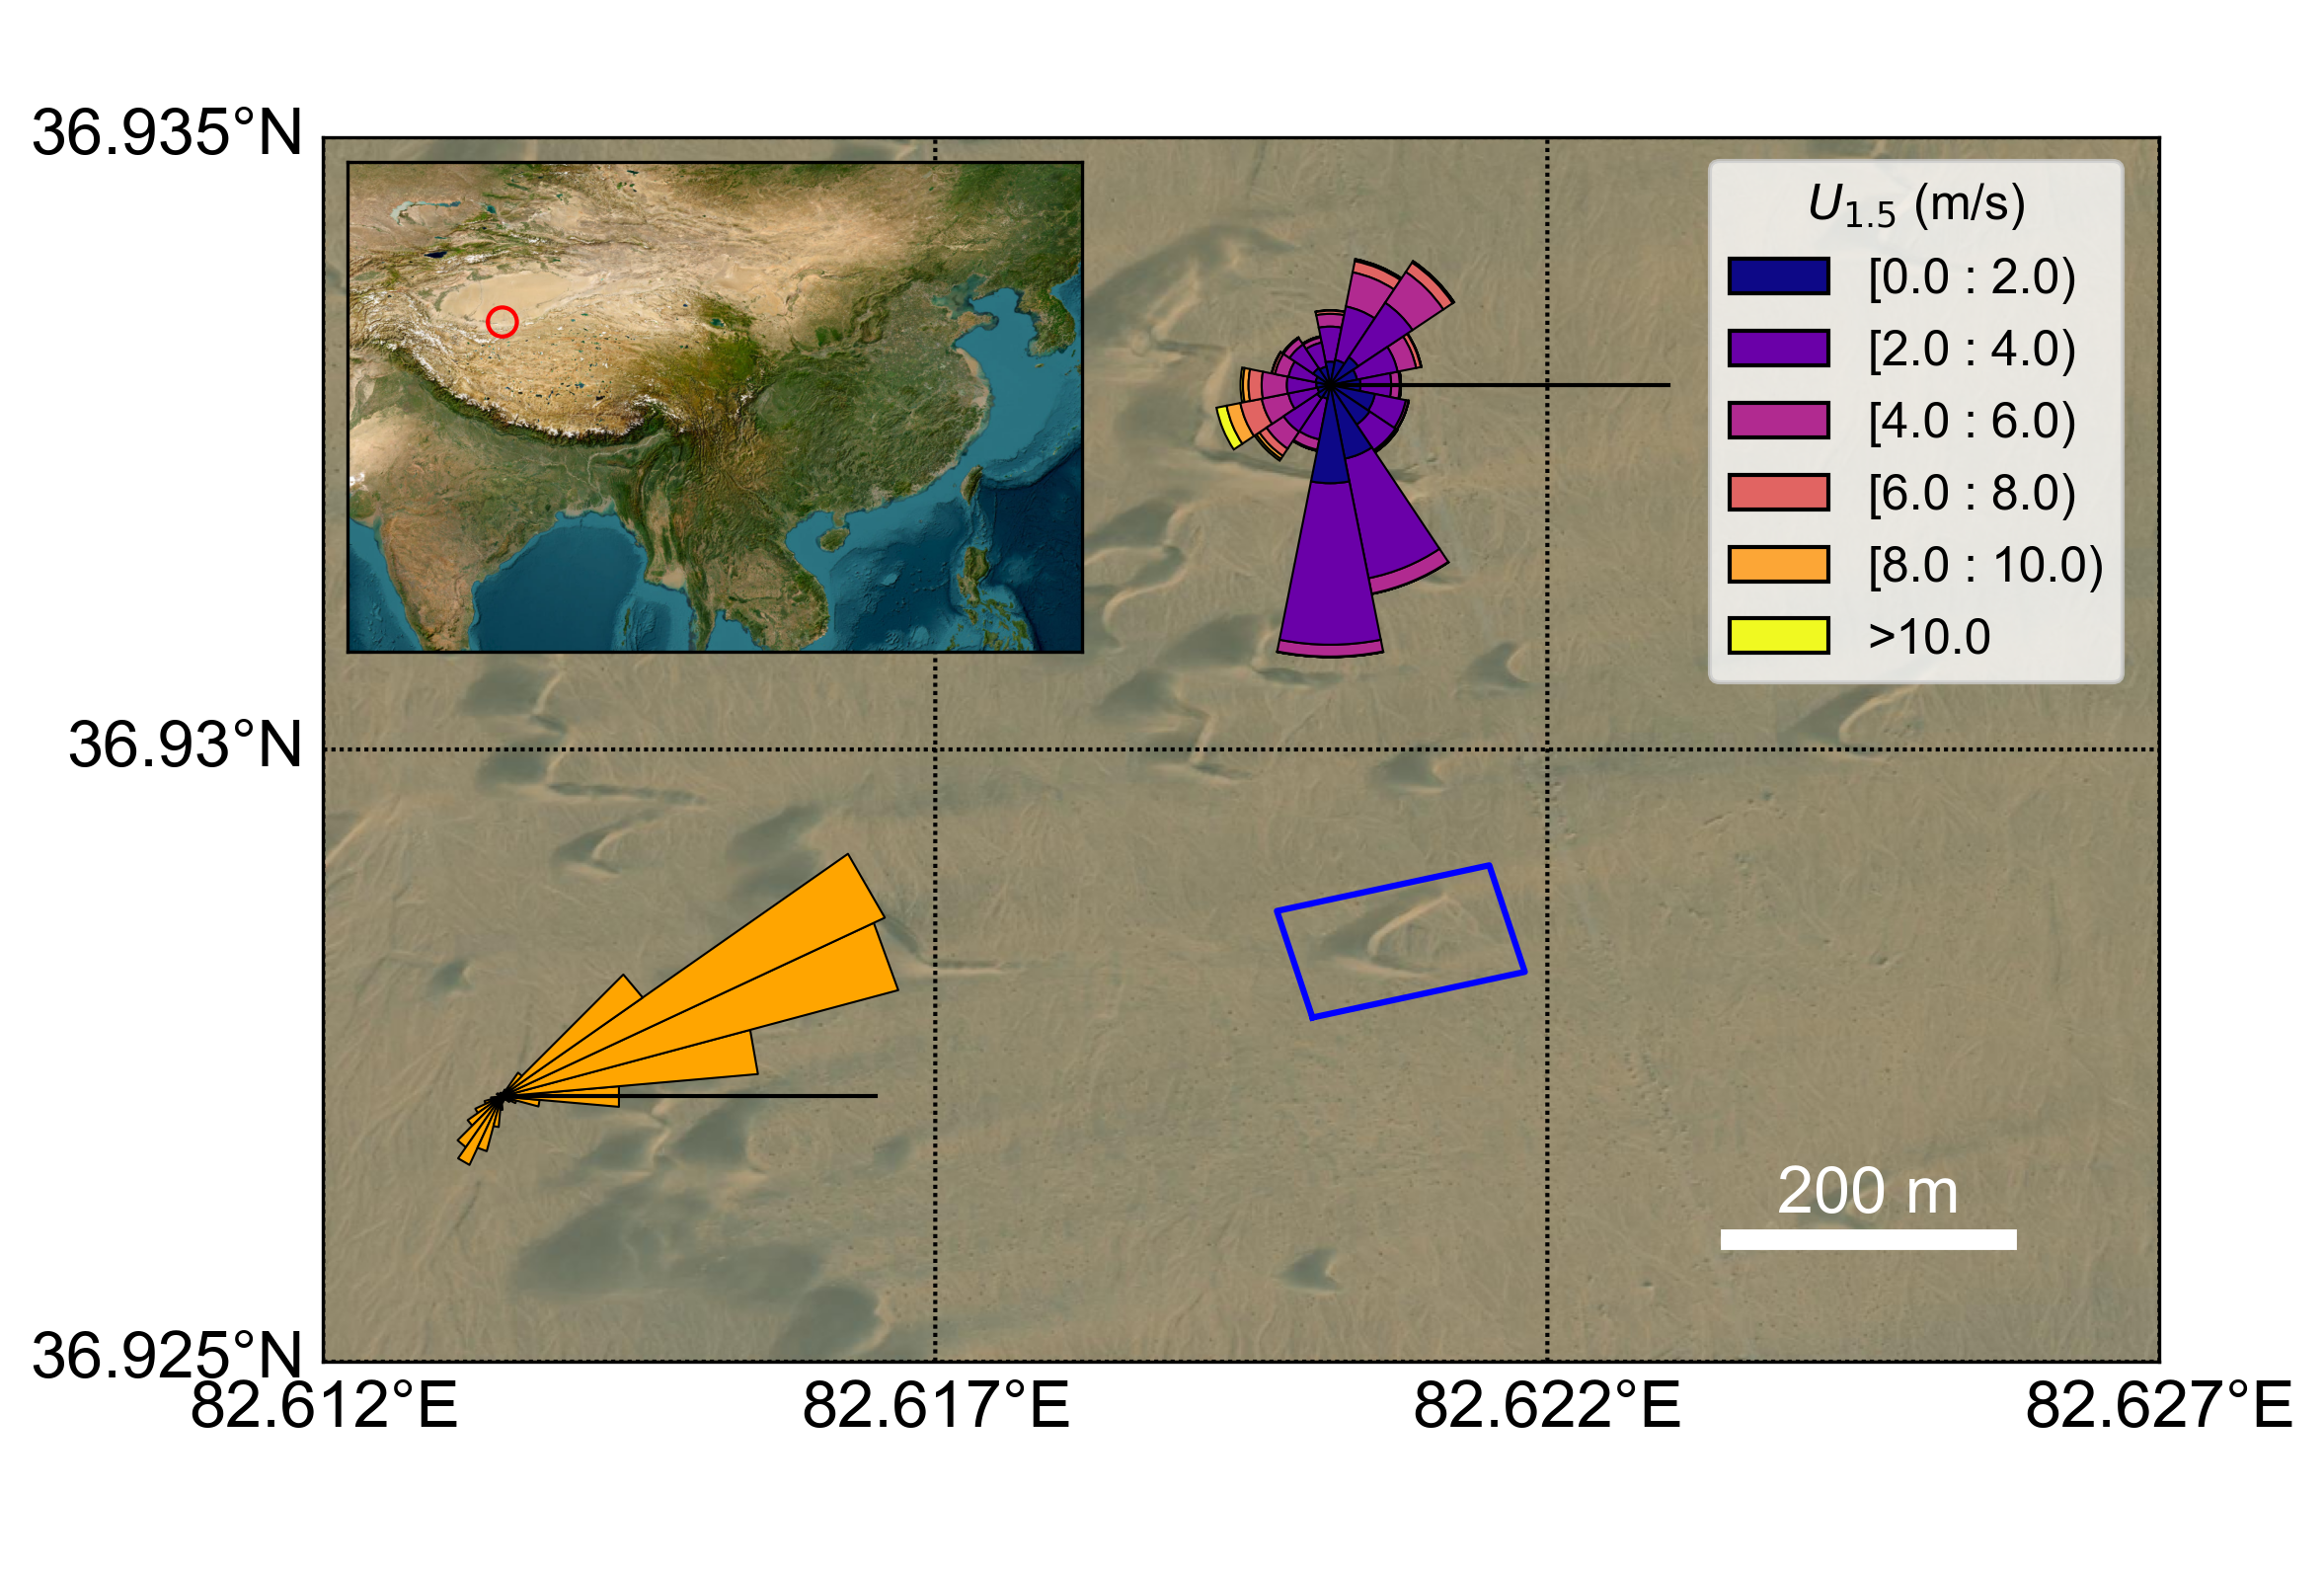

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
lw=1
fs=8
transformer = Transformer.from_crs("EPSG:32644", "EPSG:4326", always_xy=True)
lon, lat = transformer.transform(644300-10,4.088e6+90)

xmin1,xmax1 = 82.612,82.627+1e-9
ymin1,ymax1 = 36.925,36.935+1e-9
bmap = Basemap(epsg=4326,
               llcrnrlon=xmin1, llcrnrlat=ymin1,
               urcrnrlon=xmax1, urcrnrlat=ymax1)
bmap.arcgisimage(xpixels=1000,verbose=True)
bmap.drawmeridians(np.arange(xmin1,xmax1+0.005,0.005),linewidth=lw,color='k',labels=[True,False,False,True],fontsize=2*fs)
bmap.drawparallels(np.arange(ymin1,ymax1+0.005,0.005),linewidth=lw,color='k',labels=[True,False,False,True],fontsize=2*fs)

geod = Geod(ellps="WGS84")


# rotate
rect = np.array([[0,0],[160,0],[160,100],[0,100],[0,0]])
theta_degrees = 15

theta_radians = np.radians(theta_degrees)

R = np.array([[np.cos(theta_radians), -np.sin(theta_radians)],
              [np.sin(theta_radians), np.cos(theta_radians)]])

rect_rot = rect @ R.T
geod = Geod(ellps='WGS84')

# transform offsets to lon lat
lons, lats = [], []
for dx, dy in rect_rot:
    dist = np.hypot(dx, dy)                      # distance (m)
    azimuth = np.degrees(np.arctan2(dx, dy))     # orientation (deg, N=0, E=90)
    lon_pt, lat_pt, _ = geod.fwd(lon, lat, azimuth, dist)
    lons.append(lon_pt)
    lats.append(lat_pt)

ax.plot(lons, lats, 'b-')

scalebar_len_m = 200  # 200 m
lon0, lat0 = 82.6235, 36.926  # locatated at lower right corner 
lon1, lat1, _ = geod.fwd(lon0, lat0, 90, scalebar_len_m)  # E=90
ax.plot([lon0, lon1], [lat0, lat0], 'w-', lw=5)
ax.text((lon0+lon1)/2, lat0+0.0006, "200 m", ha='center', va='top', color='w',fontsize=2*fs)

axins1 = inset_axes(ax, width="40%", height="40%", loc='upper left')
xmin0,xmax0 = 70,130
ymin0,ymax0 = 10,50
bmap2 = Basemap(epsg=4326,
               llcrnrlon=xmin0, llcrnrlat=ymin0,
               urcrnrlon=xmax0, urcrnrlat=ymax0)
bmap2.arcgisimage(xpixels=1000,verbose=True)
axins1.scatter(lon, lat, s=50, marker='o', facecolor='none', edgecolors='r')

axins2 = ax.figure.add_axes([-0.05,0.05,0.5,0.5], projection='polar')
af0 = -15 # for Taklamakan
z01 = 1.5 # wind speed is measured at 1.5m show in Fig.X

dw = pd.read_excel('/Users/ylin0188/Desktop/code box/dfsframework code/Taklamakan Barchan/Wind_TK.xlsx', sheet_name='Sheet2')
time_col = dw.columns[0]
wind_dir_col = dw.columns[1]
wind_speed_col = dw.columns[2]
dw = dw.rename(columns={time_col:'time',wind_dir_col: 'wind_direction', wind_speed_col: 'wind_speed'})
del wind_dir_col, wind_speed_col,time_col

dw['time']=pd.to_datetime(dw['time'])
dw['speed'] = pd.to_numeric(dw['wind_speed'], errors='coerce')
dw['direction'] = pd.to_numeric(dw['wind_direction'], errors='coerce')
dw = dw.drop(['wind_speed', 'wind_direction'], axis=1)

da = 10
mAf = np.arange(-180,180+da,da)
mAmidf = mAf[1:]-da/2
uKHMN = dw.speed
qKHMN = flux(uKHMN ,z01,z00)



aKHMN = dw.direction
aKHMN = bearing_2_pm180_af0(aKHMN,af0)

               


pq2aa = np.empty(len(mAmidf))
for i in range(len(mAmidf)):
    pq2aa[i] = np.sum(qKHMN[(aKHMN>=mAf[i])&(aKHMN<mAf[i+1])])
pq2aa = pq2aa/np.sum(qKHMN)

for i in range(len(mAmidf)):
    axins2.fill_between([(mAf[i]+af0)/180*np.pi,(mAf[i+1]+af0)/180*np.pi],pq2aa[i],lw=0.5,edgecolor='k',facecolor='orange')

    
axins2.plot([0,0],[0,0.20],color='k',label='$P = 0.20$',lw=lw)
axins2.axis('off')


axins3 = ax.figure.add_axes([0.35, 0.5, 0.4, 0.4], projection='windrose', facecolor='None')

uKHMN = dw.speed
aKHMN = dw.direction
axins3.bar(aKHMN, uKHMN, normed=True, opening=1, edgecolor='k', 
           bins=np.arange(0, 12, 2), cmap=plt.cm.plasma,lw=lw/2)

axins3.plot([0,0], [0,20], color='k', label='$P(U_{1.5}) = 0.2$', lw=lw)
axins3.legend(title='$U_{1.5}$ (m/s)', 
              loc='upper right', 
              bbox_to_anchor=(1.65, 0.85), 
              fontsize=12,  
              title_fontsize=12)  
axins3.set_xticklabels([])
axins3.set_yticklabels([])
axins3.axis('off')


del xmax0, xmin0, ymax0, ymin0, mAf, mAmidf, geod, bmap,bmap2,axins1,axins2,axins3,xmax1, xmin1, ymax1, ymin1, R, rect, rect_rot,lons,lats,lon0,lat0,lon1,lat1,transformer,lon,lat,lon_pt,lat_pt,dx,dy,dist,azimuth,lw,scalebar_len_m